## Classification of Handwritten and Printed Text

In [1]:
# import libraries

import pandas as pd
import numpy as np
import PIL
from PIL import Image
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from os import listdir
from os.path import isfile, join
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
pytesseract.pytesseract.tesseract_cmd = '/home/ec2-user/anaconda3/envs/JupyterSystemEnv/bin/tesseract'

Using TensorFlow backend.


In [2]:
# read folders containing images having handwritten and printed text 

hand_path = 'Handwritten/'
hand_files = [f for f in listdir(hand_path) if isfile(join(hand_path, f))]
# Source: https://www.reddit.com/r/Handwriting/

print_path = 'Printed/'
print_files = [f for f in listdir(print_path) if isfile(join(print_path, f))]
# Source: https://courses.cs.vt.edu/csonline/AI/Lessons/VisualProcessing/OCRscans.html

### Image Preprocessing

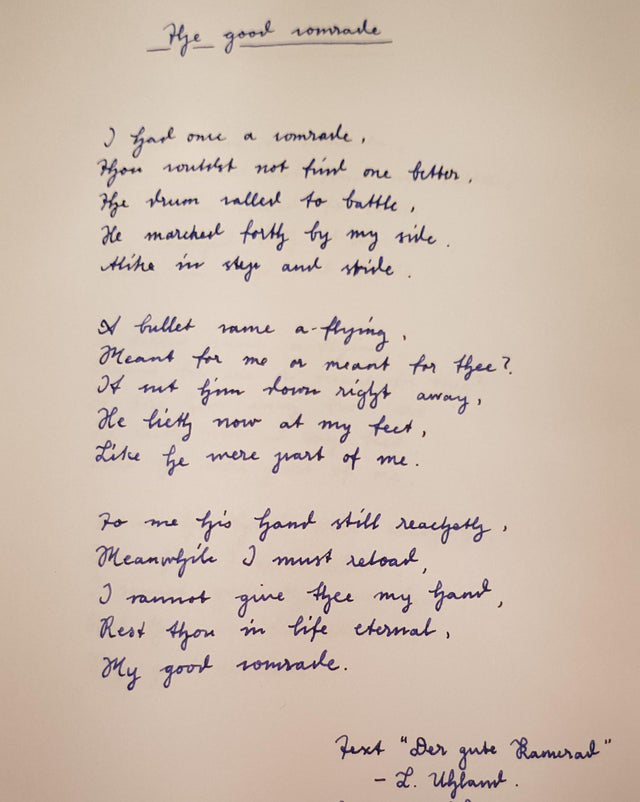

In [3]:
# sample image containing handwritten text

PIL.Image.open("Handwritten/3.jpg")

In [4]:
# preprocessing handwritten text

crop_img_list_hand = []
proj_list_hand = []
text_list_hand = []

# loop through the files in directory
for file in hand_files:
    img_file = hand_path + "/" + file
    print(img_file)
    img = cv2.imread(img_file)

    # image preprocessing
    median = cv2.medianBlur(img, 1)
    gray = cv2.cvtColor(median, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    
    # deskew image
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = gray.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    gray = cv2.warpAffine(gray, M, (w, h),
    flags = cv2.INTER_CUBIC, borderMode = cv2.BORDER_REPLICATE)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    # remove horizontal lines
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,1))
    detected_hlines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    conth = cv2.findContours(detected_hlines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    conth = conth[0] if len(conth) == 2 else conth[1]
    for h in conth:
        cv2.drawContours(gray, [h], -1, (255,255,255), 2)
               
    # Remove vertical lines
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,25))
    detected_vlines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
    contv = cv2.findContours(detected_vlines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contv = contv[0] if len(contv) == 2 else contv[1]
    for v in contv:
        cv2.drawContours(gray, [v], -1, (255,255,255), 2)    
    
    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
    result = 255 - cv2.morphologyEx(255 - gray, cv2.MORPH_CLOSE, repair_kernel, iterations=1)
    
    # text recognition
    d = pytesseract.image_to_data(gray, output_type=Output.DICT)
    # draw bounded boxes
    n_boxes = len(d['level'])
    gray_bounded = np.copy(gray)
    for i in range(n_boxes-1):
        text_all = ''
        text = ''
        if len(d['text'][i]) >1:
            text_all = d['text'][i]
            text = ''.join(e for e in text_all if e.isalnum())
        if len(text) > 1 :
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            if text.isalpha():
                cv2.rectangle(gray_bounded, (x, y), (x + w, y + h), (50, 50, 50), 2)
                crop_img = gray[y:y+h, x:x+w]
                gaus = cv2.adaptiveThreshold(crop_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 20)
                crop_img_list_hand.append(gaus)
                # horizontal projection
                proj = np.sum(gaus,0)
                proj_list_hand.append(np.reshape(proj,(-1,1)))
                text_list_hand.append(text)
            else:
                cv2.rectangle(gray_bounded, (x, y), (x + w, y + h), (50, 50, 50), 1)

Handwritten//2.jpg
Handwritten//7.jpg
Handwritten//1.jpg
Handwritten//4.jpg
Handwritten//3.jpg
Handwritten//6.jpg
Handwritten//5.jpg


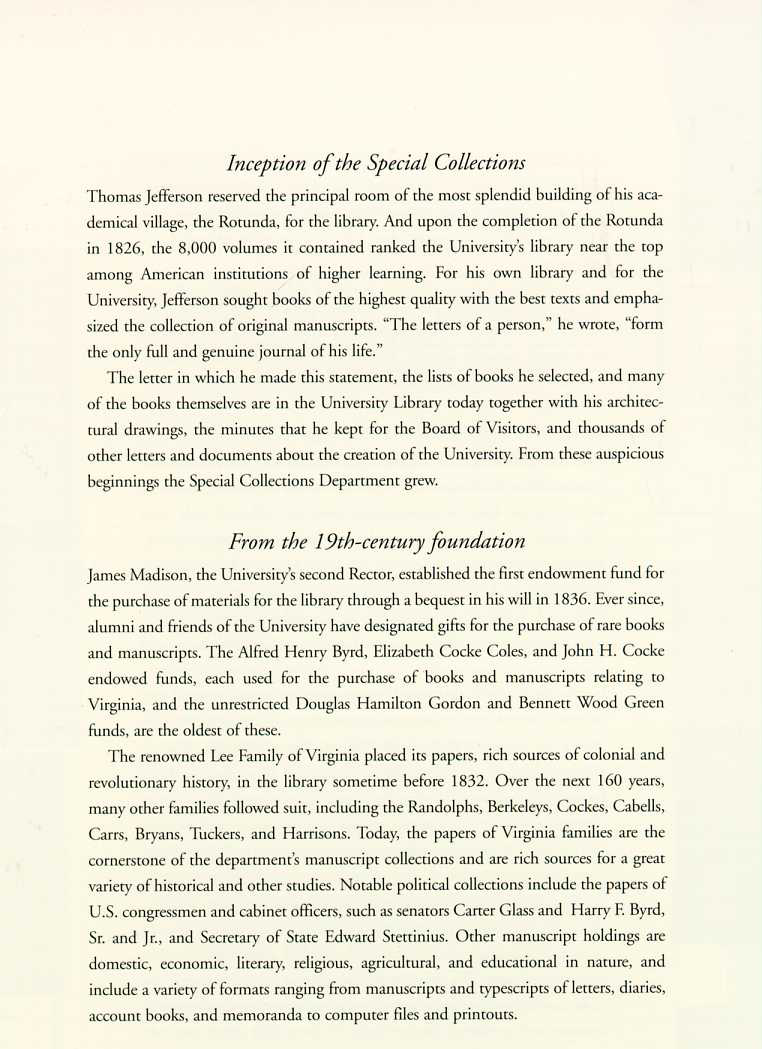

In [5]:
# sample image containing printed text

PIL.Image.open("Printed/3.jpg")

In [6]:
# preprocessing printed text

crop_img_list_print = []
proj_list_print = []
text_list_print = []

# loop through the files in directory
for file in print_files:
    img_file = print_path + "/" + file
    print(img_file)
    img = cv2.imread(img_file)

    # image preprocessing
    median = cv2.medianBlur(img, 1)
    gray = cv2.cvtColor(median, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    
    # deskew image
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = gray.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    gray = cv2.warpAffine(gray, M, (w, h),
    flags = cv2.INTER_CUBIC, borderMode = cv2.BORDER_REPLICATE)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    # remove horizontal lines
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,1))
    detected_hlines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    conth = cv2.findContours(detected_hlines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    conth = conth[0] if len(conth) == 2 else conth[1]
    for h in conth:
        cv2.drawContours(gray, [h], -1, (255,255,255), 2)
               
    # Remove vertical lines
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,25))
    detected_vlines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
    contv = cv2.findContours(detected_vlines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contv = contv[0] if len(contv) == 2 else contv[1]
    for v in contv:
        cv2.drawContours(gray, [v], -1, (255,255,255), 2)    
    
    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
    result = 255 - cv2.morphologyEx(255 - gray, cv2.MORPH_CLOSE, repair_kernel, iterations=1)
    
    # text recognition
    d = pytesseract.image_to_data(gray, output_type=Output.DICT)
    # draw bounded boxes
    n_boxes = len(d['level'])
    gray_bounded = np.copy(gray)
    for i in range(n_boxes-1):
        text_all = ''
        text = ''
        if len(d['text'][i]) >1:
            text_all = d['text'][i]
            text = ''.join(e for e in text_all if e.isalnum())
        if len(text) > 1 :
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            if text.isalpha():
                cv2.rectangle(gray_bounded, (x, y), (x + w, y + h), (50, 50, 50), 2)
                crop_img = gray[y:y+h, x:x+w]
                gaus = cv2.adaptiveThreshold(crop_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 20)
                crop_img_list_print.append(gaus)
                # horizontal projection
                proj = np.sum(gaus,0)
                proj_list_print.append(np.reshape(proj,(-1,1)))
                text_list_print.append(text)
            else:
                cv2.rectangle(gray_bounded, (x, y), (x + w, y + h), (50, 50, 50), 1)

Printed//2.jpg
Printed//7.jpg
Printed//1.jpg
Printed//4.jpg
Printed//3.jpg
Printed//6.jpg
Printed//5.jpg


### Data Preprocessing of Horizontal Projections

In [7]:
# number of text snippets in the handwritten and printed images

print(len(proj_list_hand))
print(len(proj_list_print))

523
1950


In [8]:
# convert projections into arrays

proj_arr_hand = np.array(proj_list_hand)
proj_hand = np.reshape(proj_arr_hand, (-1, 1))
proj_arr_print = np.array(proj_list_print)
proj_print = np.reshape(proj_arr_print, (-1, 1))

In [9]:
# normalize values

scaler_hand = MinMaxScaler()
proj_scaled_hand = []
for i in proj_hand:
    proj_scaled_hand.append(scaler_hand.fit_transform(i[0]))

scaler_print = MinMaxScaler()
proj_scaled_print = []
for j in proj_print:
    proj_scaled_print.append(scaler_print.fit_transform(j[0]))

In [10]:
# check out the list of handwritten text snippets

for i in range(0,524):
    print(text_list_hand[i])

Tegan
ge
Chapher
LP
near
the
surface
hes
itt
tan
ae
Bee
cei
epiptlagie
tall
aie
aly
alle
yénomes
ore
how
thay
Ble
wos
ae
arg
ie
er
os
rn
pet
ena
oe
cha
pee
aia
Pak
te
sulin
daar
pada
ot
alps
honsparant
rulalives
of
tea
ett
eed
ral
Srsprisms
Trak
swim
crn
ancig
fe
maveagsval
the
currant
drag
bb
sto
leat
nablon
redce
shan
Sen
Pt
Ruel
ttle
ear
Hah
rauclene
organtorn
foo
luca
ab
suchas
bak
remina
underanlr
pleushon
bosly
prajeds
Yrrmagh
surface
inl
air
Chupler
fle
The
scaan
depths
Yoo
hutlight
world
TAvmasepalagic
eone
where
main
Yaanmodine
ocars
Tralee
animale
mesopdlagecomnanthy
FE
mee
Qe
fs
Lert
trou
de
ee
Vhafo
aie
Laucenty
bo
jae
Sishrcletlso
One
ke
real
olethate
LY
letters
fliz
bere
ye
ave
lo
fe
fmt
Fatbetn
WIG
LE
Mon
Two
Wied
Thi
Ft
Sat
Sun
aN
ut
eae
Peewee
Oare
an
ie
ee
Ue
Ricks
ani
Daae
me
pel
lek
SE
Poveveh
nan
esse
named
sees
naga
he
money
ina
be
and
went
tte
Talt
vy
bannts
ont
ther
tue
remained
ie
ws
to
tL
care
yy
Pnseneg
The
awl
Dos
Ab
vend
Boga
ET
idea
Hate
fe
nhe
hmenhd
Be
D

IndexError: list index out of range

Not all of these words seem to make sense or are in any dictionary, but that's okay. The concern is more to do with the style of the text rather than what the text actually means.

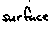

In [11]:
# check out what a handwritten text snippet looks like

Image.fromarray(crop_img_list_hand[6])

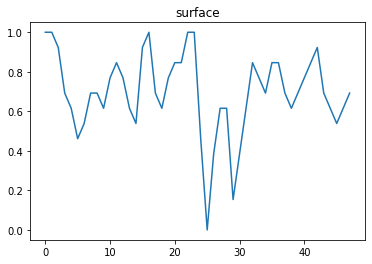

In [12]:
# projection of handwritten text snippet

plt.plot(proj_scaled_hand[6])
plt.title(text_list_hand[6])
plt.show()

In [13]:
# check out the list of printed text snippets

for i in range(0,1951):
    print(text_list_print[i])

CHAPTER
AN
OBSESSION
WITH
TIME
Marcaret
and
quarrelled
because
she
would
not
let
me
sink
her
makeshift
boat
in
the
marsh
pool
in
which
fine
steep
sea
could
be
worked
up
by
hand
in
few
seconds
More
exactly
quarrelled
with
Margaret
about
itfor
my
sister
always
remained
passive
in
the
many
disagreements
we
had
when
was
getting
on
for
eleven
and
she
was
nine
It
is
hard
as
it
always
is
with
vivid
childish
memories
to
know
how
much
of
the
incident
is
recollected
from
the
time
of
its
happening
and
how
many
suitable
details
the
mind
has
added
afterwards
in
reconstruction
The
whole
trivial
occurrenceseemsclear
in
retrospect
but
so
objectively
seen
that
it
might
be
happening
to
any
two
other
damp
and
dirty
shrillvoiced
children
playing
on
strip
of
marsh
ground
much
bigger
than
now
know
it
to
be
The
Lallie
in
the
picture
who
is
myself
is
as
visible
as
the
Margaret
so
that
probably
most
of
my
memory
of
what
followed
hangs
on
my
mothers
retelling
of
the
story
she
heard
from
Margaret
two
days
afterw

IndexError: list index out of range

In [14]:
# check out what a printed text snippet looks like

Image.fromarray(crop_img_list_print[2])

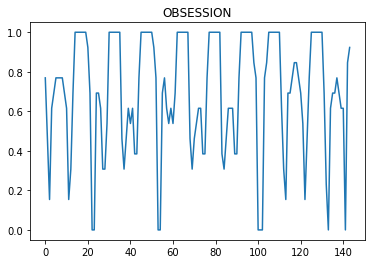

In [15]:
# projection of printed text snippet

plt.plot(proj_scaled_print[2])
plt.title(text_list_print[2])
plt.show()

The projection of the printed text snippet seems to be more regular compared to that of the handwritten snippet. Can this visual difference help in distinguishing between handwritten and printed text?

In [16]:
# consider only text snippets with at least 50 features, and take only 50 features for each snippet

hand_proj = []
for i in proj_scaled_hand:
    if (i.shape)[0] > 50:
        hand_proj.append(i[:50].T)

print_proj = []
for i in proj_scaled_print:
    if (i.shape)[0] > 50:
        print_proj.append(i[:50].T)

In [17]:
# remove the outer array of the projections

hand_projection = np.concatenate(hand_proj, 0)
print_projection = np.concatenate(print_proj, 0)

In [18]:
# create dataframes with each value of the array being one of the features

hand_projection_df = pd.DataFrame(hand_projection)
print_projection_df = pd.DataFrame(print_projection)

In [19]:
# create a column for the dependent variable or label

hand_projection_df['handwritten'] = 1
print_projection_df['handwritten'] = 0

In [20]:
# combine both dataframes to form the dataset

df = pd.concat([print_projection_df, hand_projection_df])

In [21]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,handwritten
0,0.444444,0.111111,0.555556,0.777778,0.555556,0.444444,0.333333,0.777778,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.888889,0.444444,0.000000,0.000000,0.777778,0.666667,0
1,0.769231,0.461538,0.153846,0.615385,0.692308,0.769231,0.769231,0.769231,0.769231,0.692308,...,0.615385,0.384615,0.384615,0.769231,1.000000,1.000000,1.000000,1.000000,1.000000,0
2,0.846154,0.692308,0.384615,0.384615,0.538462,0.615385,0.846154,0.692308,0.538462,0.461538,...,0.000000,0.769231,0.769231,0.846154,0.692308,0.846154,1.000000,1.000000,1.000000,0
3,0.769231,0.846154,0.923077,0.846154,0.769231,0.000000,0.000000,0.692308,0.769231,0.846154,...,0.692308,0.615385,0.000000,0.000000,0.769231,0.769231,1.000000,1.000000,1.000000,0
4,0.833333,0.166667,0.000000,0.500000,0.416667,0.500000,0.500000,0.666667,0.666667,0.666667,...,0.750000,0.500000,0.416667,0.500000,0.916667,0.916667,0.833333,0.666667,0.666667,0


In [22]:
df.shape

(765, 51)

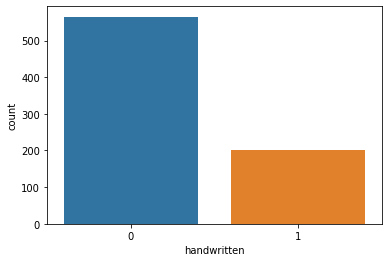

In [23]:
# number of instances of each class (0 = printed; 1 = handwritten)

sns.countplot(x='handwritten',data=df)
plt.show()

### Sequential Model

In [24]:
# create features and labels

X = df.drop('handwritten',axis = 1).values
y = df['handwritten'].values

In [25]:
# split into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=59)

In [26]:
# build a linear stack of layers with the sequential model

model = Sequential()

model.add(Dense(50, activation = "relu"))                        
model.add(Dropout(0.2))

model.add(Dense(20, activation = "relu"))                        
model.add(Dropout(0.2))

model.add(Dense(10, activation = "relu"))                        
model.add(Dropout(0.2))

model.add(Dense(1, activation = "sigmoid"))                        

model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

In [27]:
# stop the training when loss starts increasing

early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 15)

In [28]:
# training the model and saving metrics in history

model.fit(X_train, y_train, epochs = 200, verbose = 1, validation_data = (X_test, y_test), callbacks=[early_stop])

Train on 535 samples, validate on 230 samples
Epoch 1/200
535/535 [==============================] - 1s 2ms/step - loss: 0.6443 - accuracy: 0.6486 - val_loss: 0.5599 - val_accuracy: 0.7391
Epoch 2/200
535/535 [==============================] - 0s 122us/step - loss: 0.6059 - accuracy: 0.7215 - val_loss: 0.5558 - val_accuracy: 0.7391
Epoch 3/200
535/535 [==============================] - 0s 116us/step - loss: 0.5734 - accuracy: 0.7308 - val_loss: 0.5464 - val_accuracy: 0.7391
Epoch 4/200
535/535 [==============================] - 0s 114us/step - loss: 0.5615 - accuracy: 0.7346 - val_loss: 0.5439 - val_accuracy: 0.7391
Epoch 5/200
535/535 [==============================] - 0s 116us/step - loss: 0.5700 - accuracy: 0.7346 - val_loss: 0.5433 - val_accuracy: 0.7391
Epoch 6/200
535/535 [==============================] - 0s 115us/step - loss: 0.5568 - accuracy: 0.7271 - val_loss: 0.5387 - val_accuracy: 0.7391
Epoch 7/200
535/535 [==============================] - 0s 117us/step - loss: 0.5632 - 

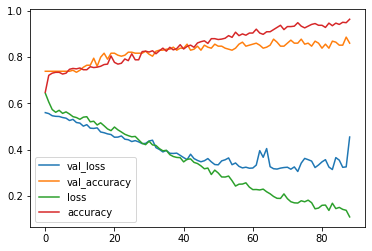

In [29]:
# plot accuracies and losses

model_loss = pd.DataFrame(model.history.history)
model_loss.plot()
plt.show()

### Predictions

In [30]:
pred = model.predict_classes(X_test)

In [31]:
# confusion matrix

print(confusion_matrix(y_test,pred))

[[167   3]
 [ 29  31]]


In [32]:
# precision and recall metrics

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       170
           1       0.91      0.52      0.66        60

    accuracy                           0.86       230
   macro avg       0.88      0.75      0.79       230
weighted avg       0.87      0.86      0.85       230



The precision and recall can possibly be improved with more samples.